###Hello Everyone! 
### I am a newbie in Kaggle and this is my first *"kernel attempt"*, which is in progress. 
### Any suggestions / comments  appreciated.  
### Thanks for checking this out :)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
from IPython.display import display, HTML

## First Step : Loading and Formatting Data
as a quick and dirty approach I decided to use the avg values over time in my first attempt

In [2]:
columns2discard = ["X2005","X2006","X2007","X2008","X2009", "X2010","X2011"]

### **1. Literacy Data**

In [3]:
literacy = pd.read_csv("adultliteracy.csv")
#change first columns name
literacy.rename(index = str, columns={"Adult..15...literacy.rate......Total":"Country"}, inplace=True)
#Discard data after 2004 since badteeth data only has 2004 data
literacy = literacy.drop(columns2discard, axis = 1)
#drop rows with no data
literacy.dropna(how="all", subset = list(literacy.columns)[1:], inplace=True)
#take the avg of literacy over time
literacy["literacy_avg"] = literacy[list(literacy.columns)[1:]].mean(axis=1,skipna = True)
literacy.drop(list(literacy.columns)[1:literacy.shape[1]-1], axis = 1, inplace = True)
literacy.head()

,Country,literacy_avg
0,Afghanistan,18.157681
1,Albania,98.712978
2,Algeria,59.752193
4,Angola,67.405416
5,Anguilla,95.407098


### **2. Bad Teeth Data**

In [4]:
#Read and Clean Data then merge with bad_teeth
badteeth = pd.read_csv("badteeth.csv")
badteeth.drop(["NA..1", "NA..2", "NA..3"], axis = 1, inplace = True)
badteeth.dropna(inplace = True)
badteeth.rename(columns = {"NA.":"Country", "X2004":"badteeth"}, inplace=True)
badteeth.sort_values(by=["badteeth"], ascending=[0], inplace = True)
badteeth.head()

,Country,badteeth
108,Martinique,6.30
143,Saint Lucia,6.00
147,Saudi Arabia,5.90
142,Saint Kitts and Nevis,5.50
149,Serbia and Montenegro,5.35


### **3. GDP Data**

In [5]:
GDP = pd.read_csv("gdp.csv")
GDP.rename(index = str, columns={"Income.per.person..fixed.2000.US..":"Country"}, inplace=True)
#Discard data after 2004 since badteeth data only has 2004 data
GDP = GDP.drop(columns2discard, axis = 1)
GDP.dropna(how="all", subset = list(GDP.columns)[1:], inplace=True)
#take the avg of GDP over time 
GDP["GDP_avg"] = GDP[list(GDP.columns)[1:]].mean(axis=1,skipna = True)
GDP.drop(list(GDP.columns)[1:GDP.shape[1]-1], axis = 1, inplace = True)
GDP.head()

,Country,GDP_avg
3,Albania,1044.215027
4,Algeria,1642.126912
6,Andorra,16818.692591
7,Angola,320.966427
9,Antigua and Barbuda,8056.655795


### **4. Health Expenditure Data**

In [6]:
health = pd.read_csv("healthexpend.csv")
health.rename(columns = {"Per.capita.government.expenditure.on.health.at.average.exchange.rate..US..":"Country"}, inplace = True)
#Discard data after 2004 since badteeth data only has 2004 data
sugar_columns2discard = columns2discard.remove("X2011") 
health = health.drop(columns2discard, axis = 1)
health.dropna(how="all", subset = list(health.columns)[1:], inplace=True)
#take the avg of health expenditure over time 
health["health_avg"] = health[list(health.columns)[1:]].mean(axis=1,skipna = True)
health.drop(list(health.columns)[1:health.shape[1]-1], axis = 1, inplace = True)

### **5. Sugar Consumption  Data**

In [7]:
sugar = pd.read_csv("sugar_consumption.csv")
sugar.rename(columns = {"NA.":"Country"}, inplace = True)
sugar.dropna(how="all", subset = list(sugar.columns)[1:], inplace=True)
sugar.drop(["NA..1"], axis = 1, inplace = True)
#take the avg of sugar over time 
sugar["sugar_avg"] = sugar[list(sugar.columns)[1:]].mean(axis=1,skipna = True)
sugar.drop(list(sugar.columns)[1:sugar.shape[1]-1], axis = 1, inplace = True)

## Second Step : Merging Data and Correlation Inspection

,badteeth,literacy_avg,GDP_avg,sugar_avg,health_avg
badteeth,1.000000,0.423500,0.348473,0.391039,0.331927
literacy_avg,0.423500,1.000000,0.572255,0.509958,0.585159
GDP_avg,0.348473,0.572255,1.000000,0.785660,0.949046
sugar_avg,0.391039,0.509958,0.785660,1.000000,0.768675
health_avg,0.331927,0.585159,0.949046,0.768675,1.000000


/Users/bengin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


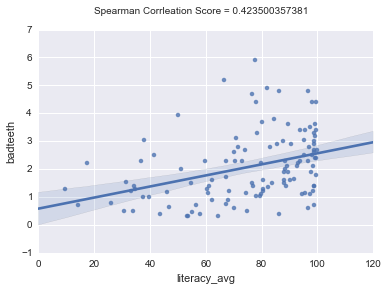

In [8]:
#Bad Teeth seems to be most correlated with literacy_avg
#and literacy is most correlated with gdp and health expenditure
#Surprisingly sugar consumption is not very well correlated with bad teeth
#we may discover a more intiutive relationship between bad teeth and sugar if we look at all data instead of considering the avg.
all_data = badteeth.merge(literacy,on='Country', how = "inner").merge(GDP,on='Country', how = "inner").merge(sugar,on='Country', how = "inner").merge(health,on='Country', how = "inner")
display(all_data.corr(method = "spearman"))
fig = plt.figure()
fig.suptitle("Spearman Corrleation Score = " + str(all_data.corr("spearman").badteeth["literacy_avg"]))
sns.regplot(x="literacy_avg", y="badteeth", data=all_data);

## Third Step : Linear Model
It seems like in case we use the parameter averages the best model to predict bad teeth is:
bad teeth ~ gdp + health + sugar + literacy

,coefficients,features
0,0.016438,literacy_avg
1,0.000041,GDP_avg
2,0.006615,sugar_avg
3,-0.001529,health_avg


'Score for : bad teeth ~ gdp + health + sugar + literacy : 0.198511628394'

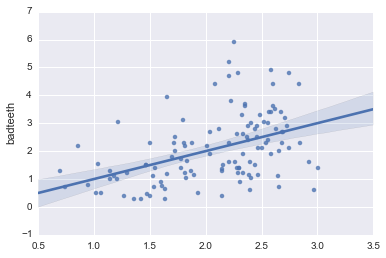

In [9]:
#create a linear regression object
lm = LinearRegression()
#Preapre the feature space
Features = all_data.drop(["badteeth", "Country"], axis = 1)
lm.fit(Features, all_data.badteeth)
display(pd.DataFrame({"features" : Features.columns, "coefficients":lm.coef_}))
#literacy on average seems to be the most important feature for bad teeth prediction
Predictions = lm.predict(Features)
sns.regplot(Predictions, all_data.badteeth)
"Score for : bad teeth ~ gdp + health + sugar + literacy : " + str(lm.score(Features,all_data.badteeth))

'Score for : bad teeth ~  sugar + literacy : 0.164477734611'

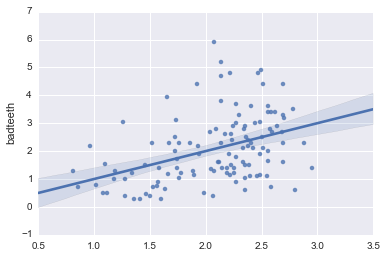

In [10]:
Features = all_data.drop(["badteeth", "Country","GDP_avg","health_avg"], axis = 1)
lm.fit(Features, all_data.badteeth)
Predictions = lm.predict(Features)
sns.regplot(Predictions, all_data.badteeth)
"Score for : bad teeth ~  sugar + literacy : " + str(lm.score(Features,all_data.badteeth))

'Score for : bad teeth ~  sugar + literacy + health: 0.18448754279'

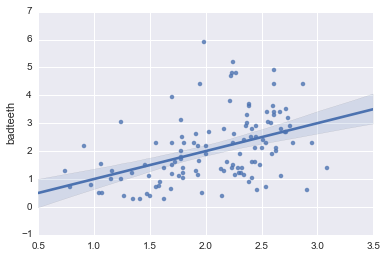

In [11]:
Features = all_data.drop(["badteeth", "Country","GDP_avg"], axis = 1)
lm.fit(Features, all_data.badteeth)
Predictions = lm.predict(Features)
sns.regplot(Predictions, all_data.badteeth)
"Score for : bad teeth ~  sugar + literacy + health: " + str(lm.score(Features,all_data.badteeth))

## What happens if we use the rate of change (slope) of our time dependent data? 
*Note: I only use the first and last data point for this calculation*

In [12]:
def find_slopes(file, first_column, column_name):
    #Load and clean the data
    data = pd.read_csv(file)
    data.rename(index = str, columns={first_column:"Country"}, inplace=True)
    data.dropna(how="all", subset = list(data.columns)[1:], inplace=True)
    if file == "sugar_consumption.csv":
        data.drop(["NA..1"], axis = 1, inplace = True)

    if file == "healthexpend.csv":
        columns2discard = ["X2005","X2006","X2007","X2008","X2009", "X2010"] 
        data = data.drop(columns2discard, axis = 1)
    elif file != "sugar_consumption.csv":
        columns2discard = ["X2005","X2006","X2007","X2008","X2009", "X2010","X2011"] 
        data = data.drop(columns2discard, axis = 1)
    
    data_melt = pd.melt(data, id_vars=['Country'], value_vars = list(data.columns)[1:])
    data_melt["variable"] = data_melt["variable"].str.replace("X","").astype(np.int64)
    data_melt.rename(index = str, columns={ "variable": "year"}, inplace = True)
    data_melt = data_melt.dropna()

    #find the earliest and latest (until 2014) entry for each country
    groups = dict(list(data_melt.groupby("Country")))
    earliest = []
    earliest_value = []
    latest = []
    latest_value = []
    for c in groups.keys():
        earliest_year = groups[c].year.min()
        earliest.append(earliest_year) 
        earliest_value.append(float(data_melt[(data_melt.Country == c) & (data_melt.year == earliest_year)].value))
        latest_year = groups[c].year.max()
        latest.append(latest_year)
        latest_value.append(float(data_melt[(data_melt.Country == c) & (data_melt.year == latest_year)].value))
 
    #calculate the rate of change (slope) per country, I only use the first and last data point for this calculation 
    data_slopes = pd.DataFrame({'Country':groups.keys(),'min_year' : earliest,'max_year' : latest,'min_value' : earliest_value,'max_value' : latest_value })
    data_slopes[column_name] = (data_slopes.max_value - data_slopes.min_value)/(data_slopes.max_year - data_slopes.min_year)
    data_slopes.sort_values(by=[column_name], ascending=[0], inplace=True)
    data_slopes = data_slopes.dropna()
    return data_slopes

In [13]:
#Just for debugging purposes I output literacy data columns.
#slope is the ratio between (max_value - min_value)/(latest - earliest year we have data for) 
literacy = find_slopes("adultliteracy.csv","Adult..15...literacy.rate......Total", "literacy_slope")
display(literacy.head())
literacy = literacy[["Country","literacy_slope"]]
GDP = find_slopes("gdp.csv","Income.per.person..fixed.2000.US..", "gdp_slope")
GDP = GDP[["Country","gdp_slope"]]
health = find_slopes("healthexpend.csv","Per.capita.government.expenditure.on.health.at.average.exchange.rate..US..", "health_slope")
health = health[["Country","health_slope"]]
sugar = find_slopes("sugar_consumption.csv","NA.", "sugar_slope")
sugar = sugar[["Country","sugar_slope"]]

,Country,max_value,max_year,min_value,min_year,literacy_slope
29,United Arab Emirates,71.235297,1985,53.514879,1975,1.772042
102,"Yemen, Rep.",54.745520,2004,37.090004,1994,1.765552
113,Burundi,59.303621,2000,22.508551,1979,1.752146
65,Chad,28.381434,2004,10.894653,1993,1.589707
84,Iran,77.000000,2002,36.518400,1976,1.556985


,badteeth,literacy_slope,gdp_slope,sugar_slope,health_slope
badteeth,1.000000,-0.290238,0.198914,0.237992,0.200649
literacy_slope,-0.290238,1.000000,-0.291648,-0.182780,-0.394017
gdp_slope,0.198914,-0.291648,1.000000,0.237292,0.657846
sugar_slope,0.237992,-0.182780,0.237292,1.000000,0.222063
health_slope,0.200649,-0.394017,0.657846,0.222063,1.000000


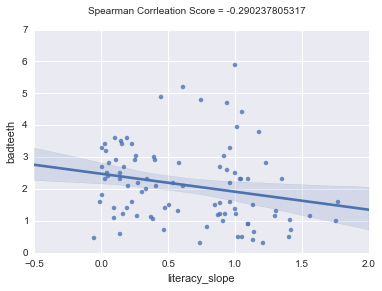

In [14]:
#When we check the correlations, we observe that there is a negative correlation between literacy decrease and bad teeth
#this observation is very intiutive
#Moreover we detect a positive correlation between gdp, sugar consumption and health expenditure with bad teeth.. 
all_data = badteeth.merge(literacy,on='Country', how = "inner").merge(GDP,on='Country', how = "inner").merge(sugar,on='Country', how = "inner").merge(health,on='Country', how = "inner")
display(all_data.corr(method = "spearman"))
fig = plt.figure()
fig.suptitle("Spearman Corrleation Score = " + str(all_data.corr("spearman").badteeth["literacy_slope"]))
sns.regplot(x="literacy_slope", y="badteeth", data=all_data);

### Linear Model build by rate of change data
Best model is the one we use all parameters

,coefficients,features
0,-0.619073,literacy_slope
1,-0.000822,gdp_slope
2,0.134396,sugar_slope
3,-0.005220,health_slope


'Score for : bad teeth ~ gdp + health + sugar + literacy : 0.0777955588356'

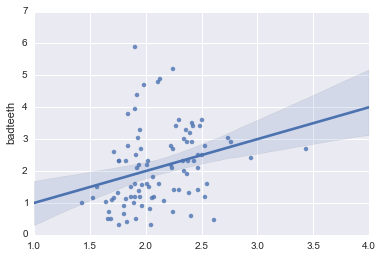

In [15]:
#create a linear regression object
lm = LinearRegression()
#Preapre the feature space
Features = all_data.drop(["badteeth", "Country"], axis = 1)
lm.fit(Features, all_data.badteeth)
display(pd.DataFrame({"features" : Features.columns, "coefficients":lm.coef_}))
#literacy on average seems to be the most important feature for bad teeth prediction
Predictions = lm.predict(Features)
sns.regplot(Predictions, all_data.badteeth)
"Score for : bad teeth ~ gdp + health + sugar + literacy : " + str(lm.score(Features,all_data.badteeth))

## Fourth Step : Visualization

## The Literacy Data

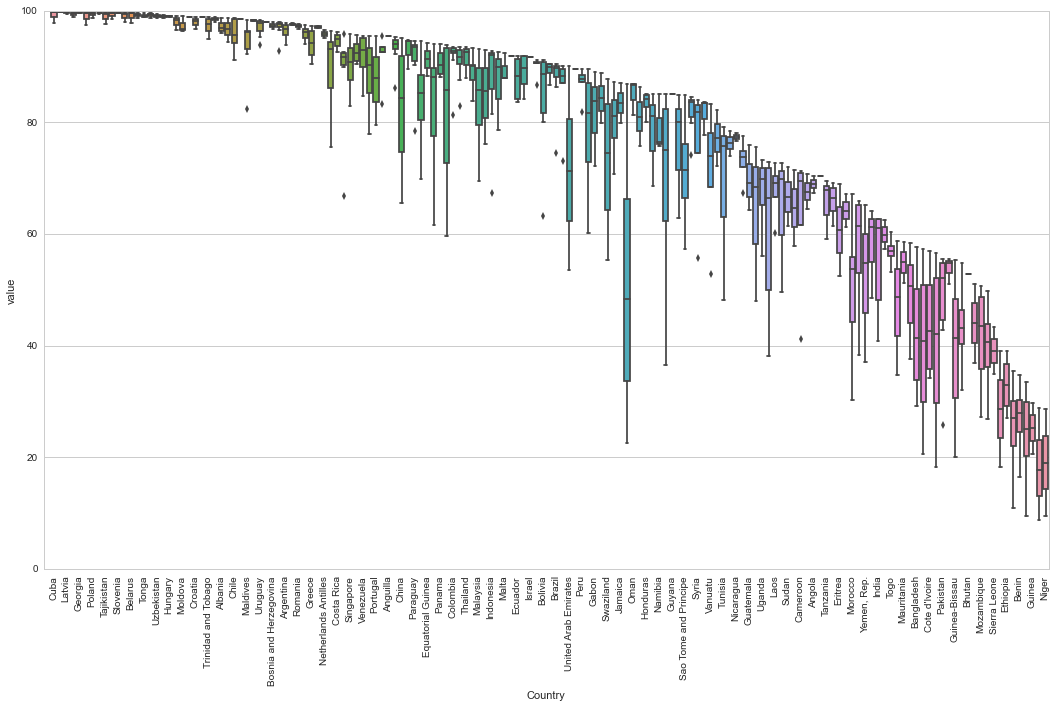

In [17]:
#organizing the rows
literacy = pd.read_csv("adultliteracy.csv")
literacy.rename(index = str, columns={"Adult..15...literacy.rate......Total":"Country"}, inplace=True)
literacy.dropna(how="all", subset = list(literacy.columns)[1:], inplace=True)
literacy_melt = pd.melt(literacy, id_vars=['Country'], value_vars = list(literacy.columns)[1:])
literacy_melt["variable"] = literacy_melt["variable"].str.replace("X","").astype(np.int64)
#Lets sort the data according to the literacy rate
literacy_melt_sorted = literacy_melt.sort_values(by=['value'], ascending=[0])
g = sns.set_style("whitegrid")
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=literacy_melt_sorted.Country, y=literacy_melt_sorted.value)
plt.setp(ax.get_xticklabels()[::2], visible=False)
g = plt.xticks(rotation=90)

In [18]:
#As Some countries have remained in the same literacy percentage, some encountered a great change during time
#which countries experienced the greatest variance?
#Top ten countries with the greatest variance in literacy
highest_var_countries = literacy_melt.groupby("Country").value.std().sort_values(ascending = False)[0:10]

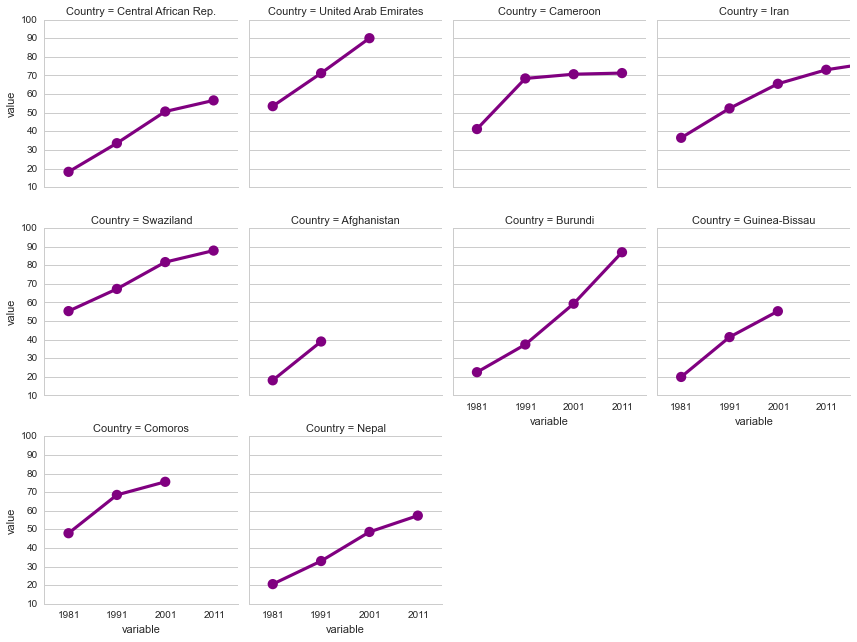

In [19]:
#I want to learn whether they improved or worsened
plot_data = literacy_melt[literacy_melt.Country.isin(list(highest_var_countries.index))].dropna()
plt.figure(figsize=(18,10))
g = sns.FacetGrid(plot_data, col="Country", col_wrap=4, size=3)
g.map(sns.pointplot, "variable", "value", color="purple", ci=None);

# GDP Data

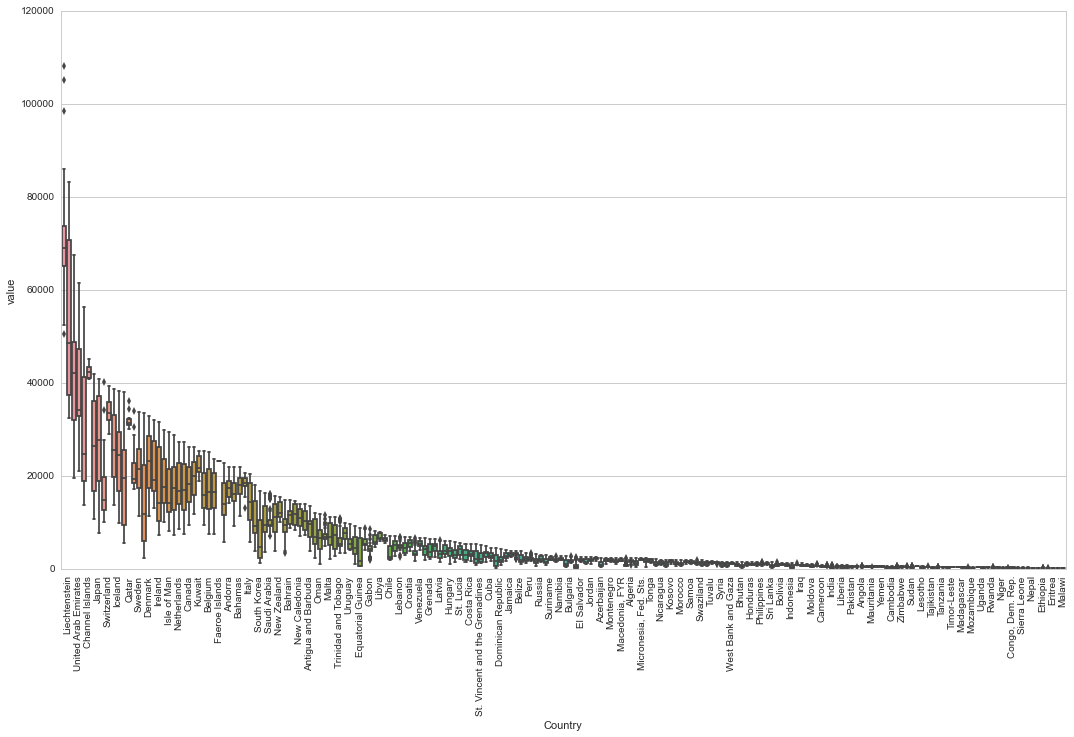

In [20]:
GDP = pd.read_csv("gdp.csv")
GDP.rename(index = str, columns={"Income.per.person..fixed.2000.US..":"Country"}, inplace=True)
GDP.dropna(how="all", subset = list(GDP.columns)[1:], inplace=True)
GDP_melt = pd.melt(GDP, id_vars=['Country'], value_vars = list(GDP.columns)[1:])
GDP_melt["variable"] = GDP_melt["variable"].str.replace("X","").astype(np.int64)
#Lets sort the data according to the literacy rate
GDP_melt_sorted = GDP_melt.sort_values(by=['value'], ascending=[0])
g = sns.set_style("whitegrid")
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=GDP_melt_sorted.Country, y=GDP_melt_sorted.value)
plt.setp(ax.get_xticklabels()[::2], visible=False)
g = plt.xticks(rotation=90)

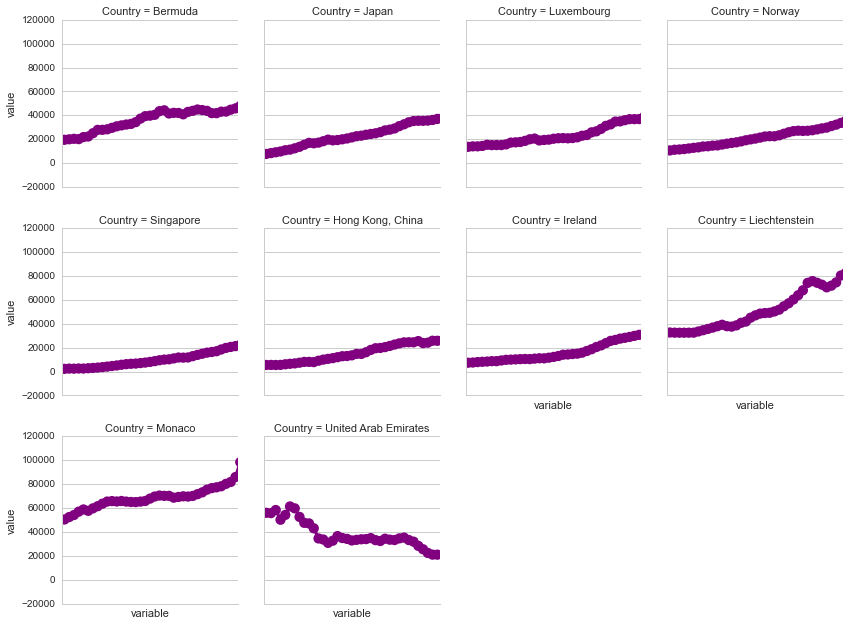

In [21]:
#Top ten countries with the greatest variance in literacy
highest_var_countries = GDP_melt.groupby("Country").value.std().sort_values(ascending = False)[0:10]
#I want to learn whether they improved or worsened
plot_data = GDP_melt[GDP_melt.Country.isin(list(highest_var_countries.index))].dropna()
g = sns.FacetGrid(plot_data, col="Country", col_wrap=4, size=3)
g.map(sns.pointplot, "variable", "value", color="purple", ci=None);
#g.set_xticklabels(rotation=30)
g.set(xticks=[])